In [1]:
import numpy as np
import pygrgl
import matplotlib.pyplot as plt

from grg_pheno_sim.effect_size import sim_grg_causal_mutation, additive_effect_sizes, samples_to_individuals, normalize_genetic_values
from grg_pheno_sim.model import grg_causal_mutation_model
from grg_pheno_sim.noise_sim import sim_env_noise
from grg_pheno_sim.normalization import normalize
from grg_pheno_sim.phenotype import convert_to_phen

from test_phenotype_sim.phenotype_test import test_variance


The following command only serves the purpose of converting the VCF zip file into a GRG that will be used for the phenotype simulation.

In [2]:
%%script bash --out /dev/null
if [ ! -f test-200-samples.grg ]; then
  grg construct --no-maf-flip -p 10 -t 2 ../data/test-200-samples.vcf.gz --out-file test-200-samples.grg
fi

In [3]:
grg_1 = pygrgl.load_immutable_grg("test-200-samples.grg") #loading in a sample grg stored in the same directory


In [4]:
rng = np.random.default_rng()

mean_1 = 0.0  
var_1 = 1.0  
model_normal = grg_causal_mutation_model("normal", mean=mean_1, var=var_1)

#simulating effect sizes using just the model
num_causal = 1000  #number of causal sites

effect_sizes = model_normal.sim_effect_size(num_causal, rng)

print("Simulated Effect Sizes:", effect_sizes)

Simulated Effect Sizes: [ 9.14987147e-01  4.48910422e-01  5.17254241e-01 -4.62161058e-02
  8.97771006e-02 -1.09557147e+00  1.24464062e+00 -1.18317200e-01
  1.10861615e+00 -1.55385652e+00 -1.30152389e+00  1.33271665e+00
  6.43620807e-01  1.16417725e+00  4.07632709e-01 -9.16331769e-02
  1.20825248e+00 -5.49704959e-01 -2.53549889e-01  1.04265865e+00
 -1.07048524e+00  6.09508896e-01 -4.29223596e-01  2.09439466e+00
  8.57905386e-01  1.84559363e-01 -2.71743046e-01 -1.53356385e+00
 -4.72172158e-01 -1.15357863e+00 -9.54494311e-01 -1.68847878e+00
  3.41935825e-01  1.33509426e+00 -2.29985875e-01  1.67293248e-01
 -1.12965641e+00 -6.14114053e-01 -4.23476413e-01  8.11625011e-01
 -2.00218647e-02 -7.66573603e-01 -8.62325634e-01 -9.79436278e-01
  9.29577447e-01 -1.34805803e-01  1.45477785e+00 -2.92868014e+00
  7.65321035e-01 -1.83286905e+00 -6.06625712e-01  4.62983559e-01
  1.26635256e+00  2.24640061e-01  1.48649372e-01 -7.58712388e-01
  8.39172298e-01  5.04086682e-01  9.97558898e-02  3.56638262e-01
 

In [5]:

trait_df_normal = sim_grg_causal_mutation(grg_1, num_causal=num_causal, model=model_normal, random_seed=1)
sample_nodes_df = additive_effect_sizes(grg_1, trait_df_normal)

In [6]:
individual_genetic_value_df = samples_to_individuals(sample_nodes_df) #non-normalized genetic value df
individual_genetic_value_df

,individual_id,genetic_value,causal_mutation_id
0,0,-16.501664,0
1,1,-2.454348,0
2,2,-17.303803,0
3,3,6.641214,0
4,4,-8.710213,0
...,...,...,...
195,195,12.536488,0
196,196,16.549154,0
197,197,5.463626,0
198,198,-0.663779,0


We first show how to simulate environmental noise before the genetic values have been normalized, with a narrow-sense heritability of 0.5.

In [7]:
phenotypes = sim_env_noise(individual_genetic_value_df, h2=0.5) #simulating environmental noise without normalizing genetic values
phenotype_df = phenotypes.phenotype_df
phenotype_df

,causal_mutation_id,individual_id,genetic_value,environmental_noise,phenotype
0,0,0,-16.501664,17.819935,1.318271
1,0,1,-2.454348,20.181175,17.726827
2,0,2,-17.303803,44.707283,27.403479
3,0,3,6.641214,-18.283511,-11.642297
4,0,4,-8.710213,6.548728,-2.161485
...,...,...,...,...,...
195,0,195,12.536488,-13.010001,-0.473513
196,0,196,16.549154,0.919723,17.468877
197,0,197,5.463626,-4.168256,1.295370
198,0,198,-0.663779,3.754751,3.090972


In [8]:
h2_used = phenotypes.get_h2() #showing the h2 factor used, can be acccessed since it is a class attribute of phenotypes
print(h2_used)

[0.5]


In [9]:
phenotype_df = normalize(phenotypes)
test1 = test_variance(phenotype_df)
print("Variance of the phenotypes is " + str(phenotype_df['phenotype'].var()))
print("Variance of the genetic values is " + str(phenotype_df['genetic_value'].var()))
print("Variance of the noise is " + str(phenotype_df['environmental_noise'].var()))
print(test1)   #tests the variance condition in the phenotypic data, expected value close to zero
phenotype_df

Variance of the phenotypes is 1.0
Variance of the genetic values is 0.5048313169460382
Variance of the noise is 0.5336204769817012
-0.03845179392773934


,causal_mutation_id,individual_id,genetic_value,environmental_noise,phenotype
0,0,0,-0.266847,0.950356,0.683509
1,0,1,0.487687,1.077187,1.564874
2,0,2,-0.309933,2.394576,2.084644
3,0,3,0.976244,-0.988895,-0.012651
4,0,4,0.151661,0.344937,0.496599
...,...,...,...,...,...
195,0,195,1.292901,-0.705635,0.587266
196,0,196,1.508437,0.042582,1.551019
197,0,197,0.912991,-0.230712,0.682279
198,0,198,0.583865,0.194862,0.778728


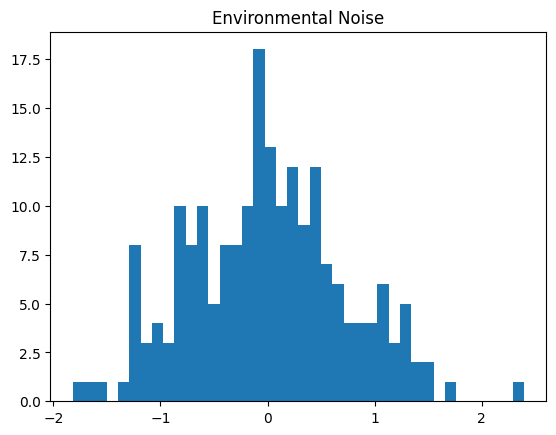

Mean of noise: -2.220446049250313e-18
Standard deviation of noise: 0.7304933107029121


In [10]:

plt.hist(phenotype_df["environmental_noise"], bins=40)
plt.title("Environmental Noise")
plt.show()
print("Mean of noise: " + str(phenotype_df['environmental_noise'].mean()))
print("Standard deviation of noise: " + str(phenotype_df['environmental_noise'].std()))

Now, we show a sample where zero noise is simulated (h2=1) by default.

In [11]:
phenotypes_zero_noise = sim_env_noise(individual_genetic_value_df) #simulating environmental noise without normalizing genetic values
phenotype_df_zero_noise = phenotypes_zero_noise.phenotype_df
phenotype_df_zero_noise

,causal_mutation_id,individual_id,genetic_value,environmental_noise,phenotype
0,0,0,-16.501664,0.0,-16.501664
1,0,1,-2.454348,0.0,-2.454348
2,0,2,-17.303803,0.0,-17.303803
3,0,3,6.641214,0.0,6.641214
4,0,4,-8.710213,0.0,-8.710213
...,...,...,...,...,...
195,0,195,12.536488,0.0,12.536488
196,0,196,16.549154,0.0,16.549154
197,0,197,5.463626,0.0,5.463626
198,0,198,-0.663779,0.0,-0.663779


In [12]:
phenotype_df_zero_noise = normalize(phenotypes_zero_noise)
print("Variance of the phenotypes is " + str(phenotype_df_zero_noise['phenotype'].var()))
print("Variance of the genetic values is " + str(phenotype_df_zero_noise['genetic_value'].var()))
print("Variance of the noise is " + str(phenotype_df_zero_noise['environmental_noise'].var()))
phenotype_df_zero_noise

Variance of the phenotypes is 1.0
Variance of the genetic values is 174.97473363027564
Variance of the noise is 0.0


,causal_mutation_id,individual_id,genetic_value,environmental_noise,phenotype
0,0,0,-16.501664,0.0,-0.375568
1,0,1,-2.454348,0.0,0.686386
2,0,2,-17.303803,0.0,-0.436209
3,0,3,6.641214,0.0,1.373995
4,0,4,-8.710213,0.0,0.213453
...,...,...,...,...,...
195,0,195,12.536488,0.0,1.819668
196,0,196,16.549154,0.0,2.123019
197,0,197,5.463626,0.0,1.284972
198,0,198,-0.663779,0.0,0.821750


In [13]:
phenotype_df_zero_noise_genetic_normalize = normalize(phenotypes_zero_noise, normalize_genetic_values=True)
print("Variance of the phenotypes is " + str(phenotype_df_zero_noise_genetic_normalize['phenotype'].var()))
print("Variance of the genetic values is " + str(phenotype_df_zero_noise_genetic_normalize['genetic_value'].var()))
print("Variance of the noise is " + str(phenotype_df_zero_noise_genetic_normalize['environmental_noise'].var()))
phenotype_df_zero_noise_genetic_normalize


Variance of the phenotypes is 1.0
Variance of the genetic values is 1.0
Variance of the noise is 0.0


,causal_mutation_id,individual_id,genetic_value,environmental_noise,phenotype
0,0,0,-0.375568,0.0,-0.375568
1,0,1,0.686386,0.0,0.686386
2,0,2,-0.436209,0.0,-0.436209
3,0,3,1.373995,0.0,1.373995
4,0,4,0.213453,0.0,0.213453
...,...,...,...,...,...
195,0,195,1.819668,0.0,1.819668
196,0,196,2.123019,0.0,2.123019
197,0,197,1.284972,0.0,1.284972
198,0,198,0.821750,0.0,0.821750


Now, we simulate environmental noise before the genetic values have been normalized, with user defined noise. If user_defined is set to True, the user must specify mean and std values to be simulated from.

In [14]:
phenotype_non_normalized_user_defined = sim_env_noise(individual_genetic_value_df, user_defined=True, mean=0, std=1) #simulating standard noise on the non-normalized genetic values
phenotype_df_non_normalized_user_defined = phenotype_non_normalized_user_defined.phenotype_df
phenotype_df_non_normalized_user_defined

,causal_mutation_id,individual_id,genetic_value,environmental_noise,phenotype
0,0,0,-16.501664,-1.151369,-17.653033
1,0,1,-2.454348,1.204685,-1.249663
2,0,2,-17.303803,-0.560524,-17.864327
3,0,3,6.641214,-0.565046,6.076168
4,0,4,-8.710213,-1.216632,-9.926844
...,...,...,...,...,...
195,0,195,12.536488,-0.429624,12.106865
196,0,196,16.549154,-0.086654,16.462500
197,0,197,5.463626,1.240977,6.704603
198,0,198,-0.663779,-1.005004,-1.668783


The user can choose to view the h2 narrow sense heritability factor for the user-defined noise as well.

In [15]:
h2_user_defined = phenotype_non_normalized_user_defined.get_h2()
print(h2_user_defined)

1.006033281777434


In [16]:
phenotype_df_non_normalized_user_defined = normalize(phenotype_non_normalized_user_defined)
print("Variance of the phenotypes is " + str(phenotype_df_non_normalized_user_defined['phenotype'].var()))
print("Variance of the genetic values is " + str(phenotype_df_non_normalized_user_defined['genetic_value'].var()))
print("Variance of the noise is " + str(phenotype_df_non_normalized_user_defined['environmental_noise'].var()))
phenotype_df_non_normalized_user_defined

Variance of the phenotypes is 1.0
Variance of the genetic values is 1.0011767483364222
Variance of the noise is 0.004856533441011526


,causal_mutation_id,individual_id,genetic_value,environmental_noise,phenotype
0,0,0,-0.375789,-0.088840,-0.464629
1,0,1,0.686790,0.089379,0.776168
2,0,2,-0.436465,-0.044147,-0.480612
3,0,3,1.374803,-0.044489,1.330315
4,0,4,0.213578,-0.093776,0.119802
...,...,...,...,...,...
195,0,195,1.820739,-0.034245,1.786494
196,0,196,2.124268,-0.008302,2.115966
197,0,197,1.285727,0.092124,1.377851
198,0,198,0.822233,-0.077768,0.744465


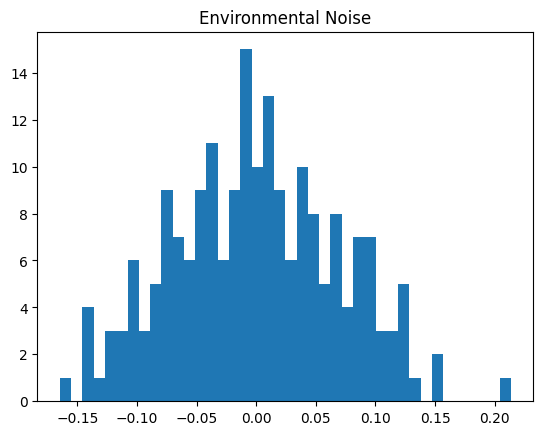

Mean of noise: 8.326672684688674e-19
Standard deviation of noise: 0.06968883297208761


In [17]:

plt.hist(phenotype_df_non_normalized_user_defined["environmental_noise"], bins=40)
plt.title("Environmental Noise")
plt.show()
print("Mean of noise: " + str(phenotype_df_non_normalized_user_defined['environmental_noise'].mean()))
print("Standard deviation of noise: " + str(phenotype_df_non_normalized_user_defined['environmental_noise'].std()))

The user could also define a custom distribution to simulate environmental noise from.

In [18]:
genetic_val_df_normalized = normalize_genetic_values(individual_genetic_value_df) #normalized genetic value df
genetic_val_df_normalized

,individual_id,genetic_value,causal_mutation_id
0,0,-0.375568,0
1,1,0.686386,0
2,2,-0.436209,0
3,3,1.373995,0
4,4,0.213453,0
...,...,...,...
195,195,1.819668,0
196,196,2.123019,0
197,197,1.284972,0
198,198,0.821750,0


We now show how to simulate environmental noise after the genetic values have been normalized, with a narrow-sense heritability of 0.25.

In [19]:
phenotype_post_normalization_h2 = sim_env_noise(genetic_val_df_normalized, h2=0.25) #simulating noise after genetic values have been normalized
phenotype_df_post_normalization_h2 = phenotype_post_normalization_h2.phenotype_df
phenotype_df_post_normalization_h2

,causal_mutation_id,individual_id,genetic_value,environmental_noise,phenotype
0,0,0,-0.375568,0.669725,0.294156
1,0,1,0.686386,0.494029,1.180415
2,0,2,-0.436209,1.200215,0.764006
3,0,3,1.373995,-0.182526,1.191469
4,0,4,0.213453,1.165563,1.379016
...,...,...,...,...,...
195,0,195,1.819668,-0.812909,1.006760
196,0,196,2.123019,-0.849020,1.273999
197,0,197,1.284972,3.917444,5.202416
198,0,198,0.821750,-0.048869,0.772881


In [20]:
phenotype_df_post_normalization_h2 = normalize(phenotype_post_normalization_h2)
print("Variance of the phenotypes is " + str(phenotype_df_post_normalization_h2['phenotype'].var()))
print("Variance of the genetic values is " + str(phenotype_df_post_normalization_h2['genetic_value'].var()))
print("Variance of the noise is " + str(phenotype_df_post_normalization_h2['environmental_noise'].var()))
test3 = test_variance(phenotype_df_post_normalization_h2)
print(test3)  #tests the variance condition in the phenotypic data, expected value is close to zero
phenotype_df_post_normalization_h2

Variance of the phenotypes is 1.0
Variance of the genetic values is 0.25525954852058896
Variance of the noise is 0.7844223029043961
-0.03968185142498504


,causal_mutation_id,individual_id,genetic_value,environmental_noise,phenotype
0,0,0,-0.189749,0.358081,0.168332
1,0,1,0.346784,0.269314,0.616098
2,0,2,-0.220387,0.626102,0.405715
3,0,3,0.694187,-0.072503,0.621683
4,0,4,0.107843,0.608595,0.716438
...,...,...,...,...,...
195,0,195,0.919355,-0.390993,0.528362
196,0,196,1.072618,-0.409238,0.663380
197,0,197,0.649209,1.998934,2.648143
198,0,198,0.415174,-0.004975,0.410199


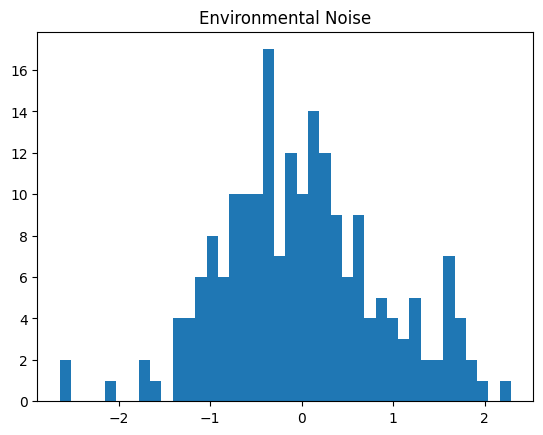

Mean of noise: -1.3322676295501878e-17
Standard deviation of noise: 0.8856761839997709


In [21]:

plt.hist(phenotype_df_post_normalization_h2["environmental_noise"], bins=40)
plt.title("Environmental Noise")
plt.show()
print("Mean of noise: " + str(phenotype_df_post_normalization_h2['environmental_noise'].mean()))
print("Standard deviation of noise: " + str(phenotype_df_post_normalization_h2['environmental_noise'].std()))

We finally show how to simulate environmental noise after the genetic values have been normalized, with a narrow-sense heritability of 1 (default case) and user defined cases for the noise.

In [22]:
phenotype_post_normalization_default_mean_and_std = sim_env_noise(genetic_val_df_normalized, user_defined=True, mean=0, std=1) #simulating noise after genetic values have been normalized with h2=1 and user defined with standard mean and std
phenotype_df_post_normalization_default_mean_and_std = phenotype_post_normalization_default_mean_and_std.phenotype_df
phenotype_df_post_normalization_default_mean_and_std

,causal_mutation_id,individual_id,genetic_value,environmental_noise,phenotype
0,0,0,-0.375568,0.235282,-0.140286
1,0,1,0.686386,-1.763654,-1.077269
2,0,2,-0.436209,0.421156,-0.015053
3,0,3,1.373995,0.560171,1.934167
4,0,4,0.213453,1.418047,1.631500
...,...,...,...,...,...
195,0,195,1.819668,0.589486,2.409154
196,0,196,2.123019,0.852844,2.975864
197,0,197,1.284972,-0.794503,0.490469
198,0,198,0.821750,0.410637,1.232387


In [23]:
phenotype_df_post_normalization_default_mean_and_std = normalize(phenotype_post_normalization_default_mean_and_std)
print("Variance of the phenotypes is " + str(phenotype_df_post_normalization_default_mean_and_std['phenotype'].var()))
print("Variance of the genetic values is " + str(phenotype_df_post_normalization_default_mean_and_std['genetic_value'].var()))
print("Variance of the noise is " + str(phenotype_df_post_normalization_default_mean_and_std['environmental_noise'].var()))
phenotype_df_post_normalization_default_mean_and_std

Variance of the phenotypes is 1.0
Variance of the genetic values is 0.4806048344664223
Variance of the noise is 0.5046053227957378


,causal_mutation_id,individual_id,genetic_value,environmental_noise,phenotype
0,0,0,-0.260365,0.173999,-0.086366
1,0,1,0.475842,-1.211777,-0.735936
2,0,2,-0.302404,0.302857,0.000453
3,0,3,0.952531,0.399231,1.351762
4,0,4,0.147978,0.993959,1.141936
...,...,...,...,...,...
195,0,195,1.261497,0.419553,1.681050
196,0,196,1.471797,0.602128,2.073925
197,0,197,0.890815,-0.539906,0.350909
198,0,198,0.569684,0.295565,0.865249


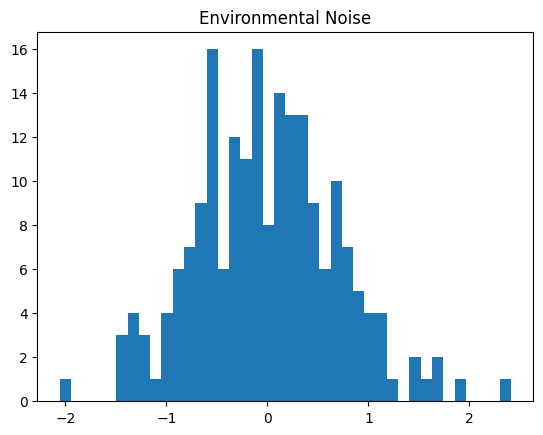

Mean of noise: -2.2204460492503132e-17
Standard deviation of noise: 0.7103557719873457


In [24]:

plt.hist(phenotype_df_post_normalization_default_mean_and_std["environmental_noise"], bins=40)
plt.title("Environmental Noise")
plt.show()
print("Mean of noise: " + str(phenotype_df_post_normalization_default_mean_and_std['environmental_noise'].mean()))
print("Standard deviation of noise: " + str(phenotype_df_post_normalization_default_mean_and_std['environmental_noise'].std()))

In [25]:
phenotype_post_normalization_unique_mean_and_std = sim_env_noise(genetic_val_df_normalized, user_defined=True, mean=1, std=2) #simulating noise after genetic values have been normalized with h2=1 and user defined mean and std
phenotype_df_post_normalization_unique_mean_and_std = phenotype_post_normalization_unique_mean_and_std.phenotype_df
phenotype_df_post_normalization_unique_mean_and_std

,causal_mutation_id,individual_id,genetic_value,environmental_noise,phenotype
0,0,0,-0.375568,5.275272,4.899704
1,0,1,0.686386,1.831467,2.517853
2,0,2,-0.436209,-0.843526,-1.279734
3,0,3,1.373995,0.777825,2.151820
4,0,4,0.213453,-0.797651,-0.584198
...,...,...,...,...,...
195,0,195,1.819668,2.110403,3.930072
196,0,196,2.123019,-1.246965,0.876054
197,0,197,1.284972,3.901803,5.186775
198,0,198,0.821750,1.028223,1.849973


In [26]:
phenotype_df_post_normalization_unique_mean_and_std = normalize(phenotype_post_normalization_unique_mean_and_std)
print("Variance of the phenotypes is " + str(phenotype_df_post_normalization_unique_mean_and_std['phenotype'].var()))
print("Variance of the genetic values is " + str(phenotype_df_post_normalization_unique_mean_and_std['genetic_value'].var()))
print("Variance of the noise is " + str(phenotype_df_post_normalization_unique_mean_and_std['environmental_noise'].var()))
test5 = test_variance(phenotype_df_post_normalization_unique_mean_and_std)
phenotype_df_post_normalization_unique_mean_and_std

Variance of the phenotypes is 0.9999999999999997
Variance of the genetic values is 0.17210059311859943
Variance of the noise is 0.8090680781557303


,causal_mutation_id,individual_id,genetic_value,environmental_noise,phenotype
0,0,0,-0.155804,1.804958,1.649154
1,0,1,0.284747,0.376296,0.661043
2,0,2,-0.180961,-0.733426,-0.914387
3,0,3,0.570002,-0.060808,0.509194
4,0,4,0.088551,-0.714394,-0.625843
...,...,...,...,...,...
195,0,195,0.754890,0.492012,1.246902
196,0,196,0.880735,-0.900792,-0.020058
197,0,197,0.533071,1.235175,1.768245
198,0,198,0.340903,0.043070,0.383973


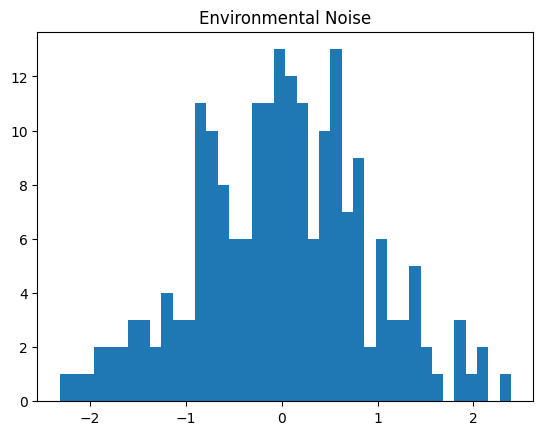

Mean of noise: -2.6645352591003756e-17
Standard deviation of noise: 0.899482116640309


In [27]:

plt.hist(phenotype_df_post_normalization_unique_mean_and_std["environmental_noise"], bins=40)
plt.title("Environmental Noise")
plt.show()
print("Mean of noise: " + str(phenotype_df_post_normalization_unique_mean_and_std['environmental_noise'].mean()))
print("Standard deviation of noise: " + str(phenotype_df_post_normalization_unique_mean_and_std['environmental_noise'].std()))

We show an example of converting the final phenotypes output to a standard .phen file format to be saved in the local directory.

In [28]:
local_path = 'post_noise_phenotypes.phen' #will be saved in a .phen file of this name in the local directory.
convert_to_phen(phenotype_df_post_normalization_unique_mean_and_std, local_path, include_header=True)